In [1]:
import xarray as xr
import pyorc
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from pyproj import Transformer

import subprocess
import yt_dlp

In [2]:
def get_stream_url(youtube_url: str) -> str:
    """
    Utilise yt-dlp pour extraire l'URL directe du flux (format HLS le plus qualitatif).
    """
    ydl_opts = {
        'format': 'best',
        'quiet': True,
        'no_warnings': True,
        'skip_download': True,
        'get_url': True,
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        # extract_info avec download=False retourne les métadonnées sans fichier local
        info = ydl.extract_info(youtube_url, download=False)
        return info['url']

def record_two_seconds(stream_url: str, output_path: str = 'clip2s.mp4'):
    """
    Lance FFmpeg pour capturer 2 s du flux et les enregistrer dans output_path.
    """
    cmd = [
        'ffmpeg',
        '-y',               # écrase sans demander
        '-i', stream_url,   # flux HLS
        '-t', '2',          # durée d’enregistrement = 2s
        '-c', 'copy',       # copie les flux audio/vidéo sans réencodage
        output_path
    ]
    subprocess.run(cmd, check=True)
    print(f"Clip enregistré dans '{output_path}'.")

In [4]:
url = 'https://www.youtube.com/watch?v=iLIywU61zl8'  # remplacez par votre URL
print("Récupération de l'URL du flux…")
stream = get_stream_url(url)
print("Enregistrement de 2 secondes…")
record_two_seconds(stream, output_path='./artifact/live.mp4')

Récupération de l'URL du flux…
Enregistrement de 2 secondes…
Clip enregistré dans './artifact/live.mp4'.


In [5]:
video_file = R"./artifact/live.mp4"

Scanning video: 100%|██████████| 2/2 [00:00<00:00, 16.92it/s]


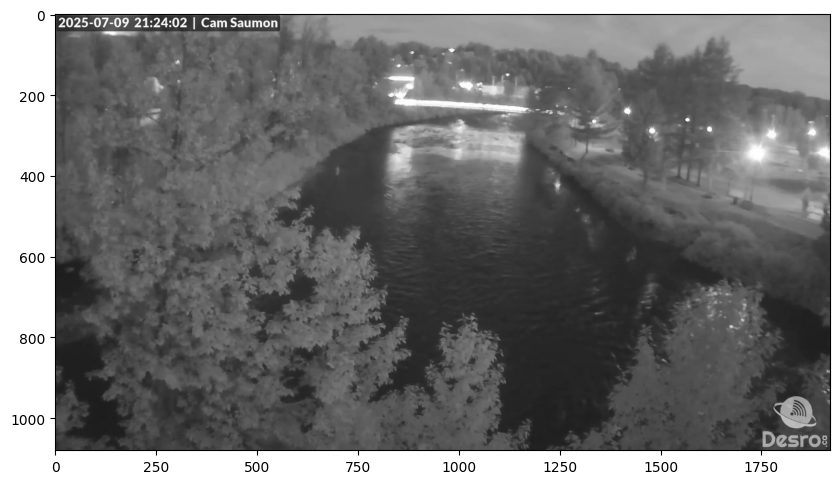

In [6]:
videofilm = pyorc.Video(video_file, start_frame=0, end_frame=1)
frame = videofilm.get_frame(0, method="rgb")

# plot frame on a notebook-style window
f = plt.figure(figsize=(10, 6))
plt.imshow(frame)

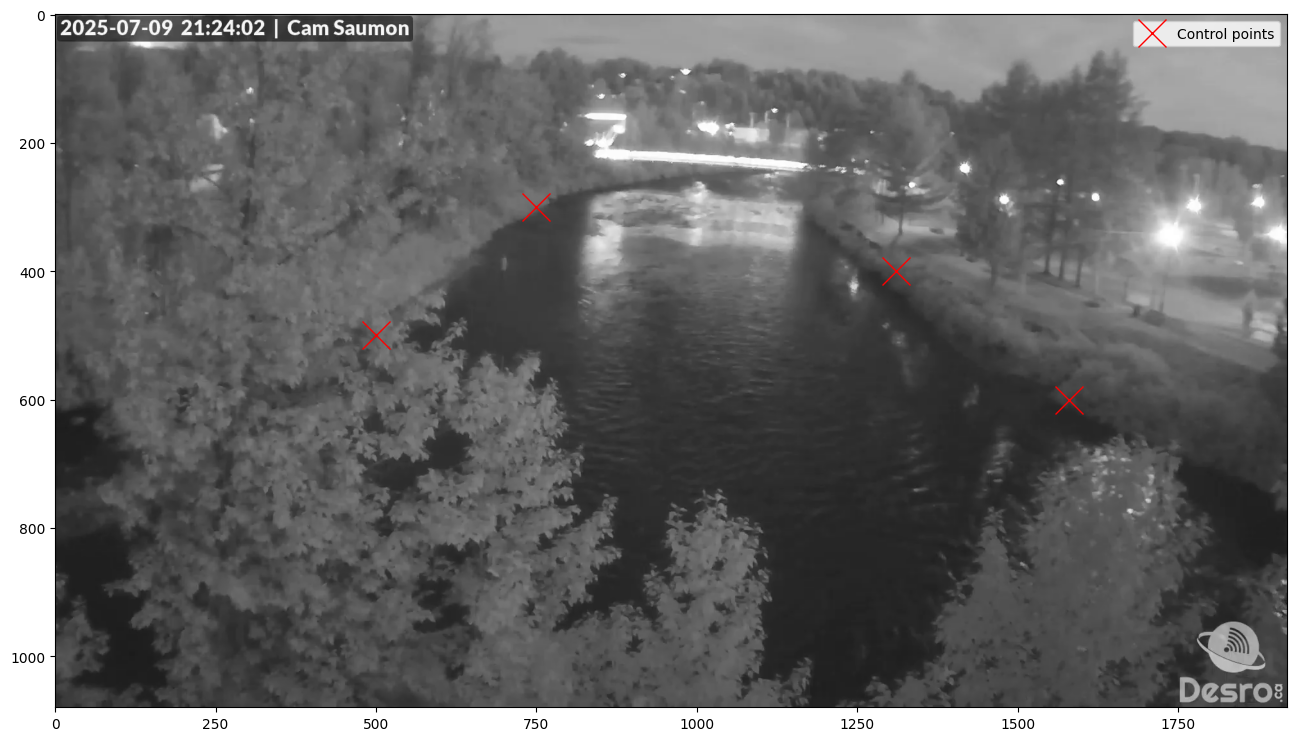

In [10]:
gcps = dict(
    src=[
        [1580, 600], # pixel bas droite     
        [1310, 400],# pixel haut droite
        [750, 300], # haut gauche
        [500, 500], # bas gauche
    ]
)

f = plt.figure(figsize=(16, 9))
plt.imshow(frame)
plt.plot(*zip(*gcps["src"]), "rx", markersize=20, label="Control points")
plt.legend()

In [13]:
pointDST =  [                              
    ( -67.22599, 48.35665785439051), #bas droit 
    ( -67.22545225101454, 48.35609547847024), #haut droit 
    ( -67.2248724691727, 48.35597651087156),  #haut gauche 
    (-67.22553331615104, 48.35667744965113) #bas gauche

]

transformer = Transformer.from_crs("epsg:4326", "epsg:32618", always_xy=True)

gcps["dst"] = [transformer.transform(lon, lat) for lon, lat in pointDST]

# # if we would use this video as survey in video, the lines below are also needed,
# # and proper values need to be filled in. They are now commented out.
# gcps["h_ref"] = <your locally measured water level during survey in>
#gcps["z_0"] = 1182.2
gcps["z_0"] = 34.5

# set the height and width
height, width = frame.shape[0:2]

# now we use everything to make a camera configuration
cam_config = pyorc.CameraConfig(height=height, width=width, gcps=gcps, crs=32618)

<GeoAxes: >

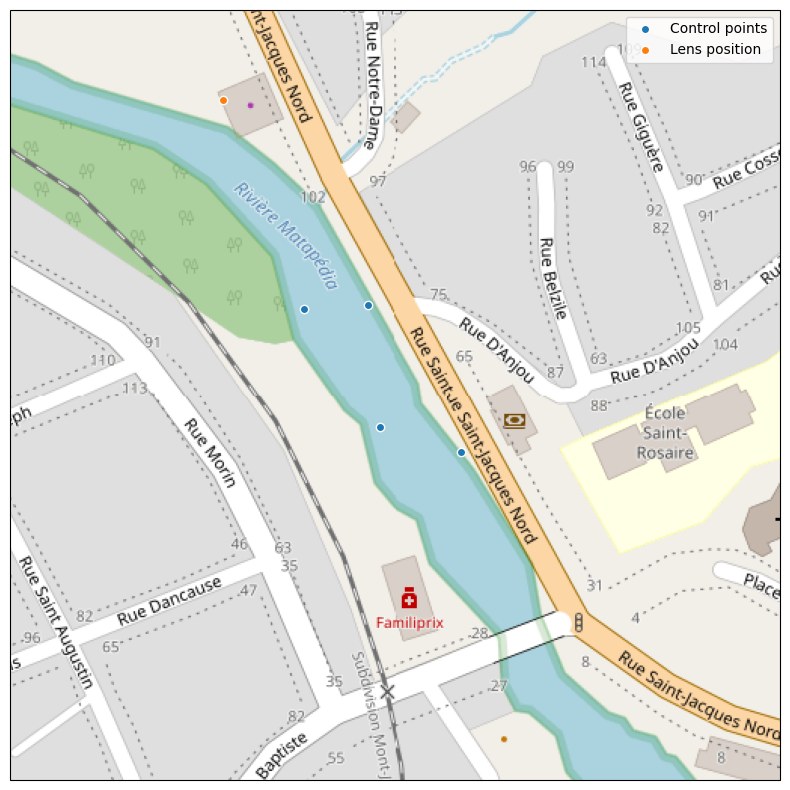

In [14]:
import cartopy.io.img_tiles as cimgt
osm_tiler = cimgt.OSM()
tiler_crs = osm_tiler.crs

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=tiler_crs)

# Ajouter les tuiles
ax.add_image(osm_tiler, 17)  # Zoom 17 (modifie selon ton besoin)

# Ajouter ensuite des éléments de pyOpenRiverCam sur ce même ax
cam_config.plot(ax=ax, mode="geographical")

In [17]:
corners = [
    [1400, 600],   # plus à droite et en bas
    [1250, 400],   # plus à droite et en haut
    [750, 350],    # plus à gauche et en haut
    [600, 550]     # plus à gauche et en bas
]
cam_config.set_bbox_from_corners(corners)
cam_config.resolution = 0.05
cam_config.window_size = 64

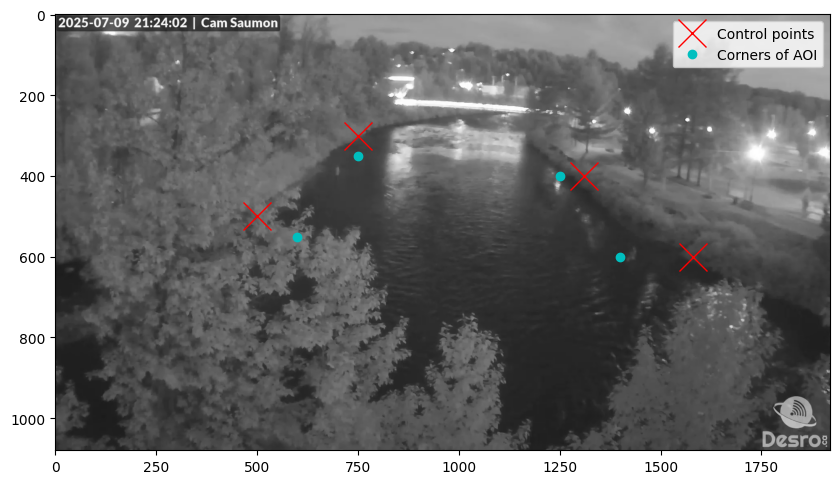

In [18]:
f = plt.figure(figsize=(10, 6))
plt.imshow(frame)
plt.plot(*zip(*gcps["src"]), "rx", markersize=20, label="Control points")
plt.plot(*zip(*corners), "co", label="Corners of AOI")
plt.legend()

C:\Users\willi\AppData\Local\Temp\ipykernel_21300\1665791959.py:16: DeprecationWarning: The camera=True option is deprecated, use mode='camera' instead. This option will be removed in a future release.
  cam_config.plot(ax=ax2, camera=True)


<Axes: xlabel='column [-]', ylabel='row [-]'>

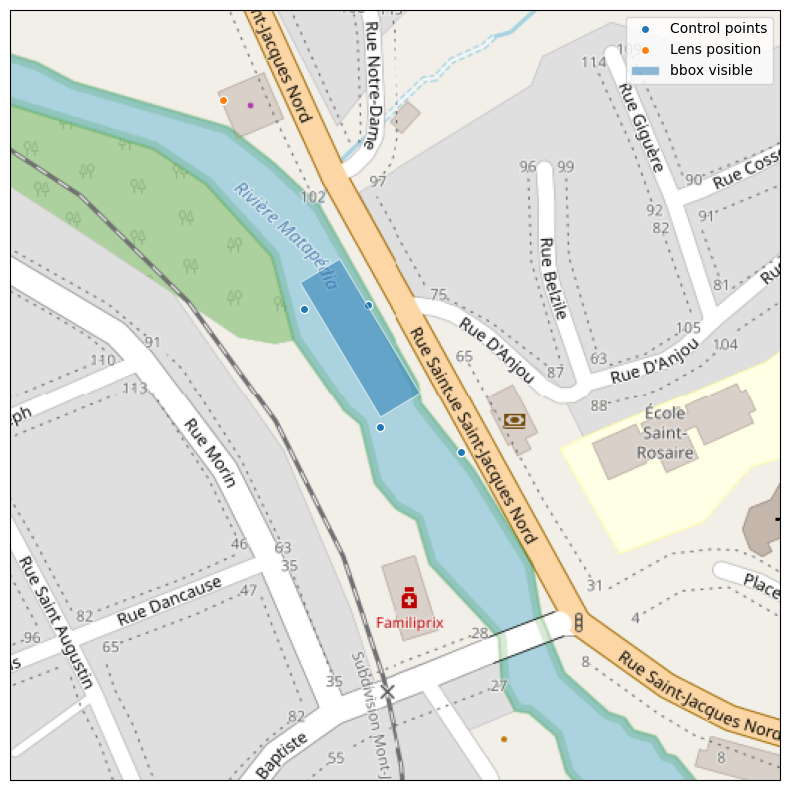

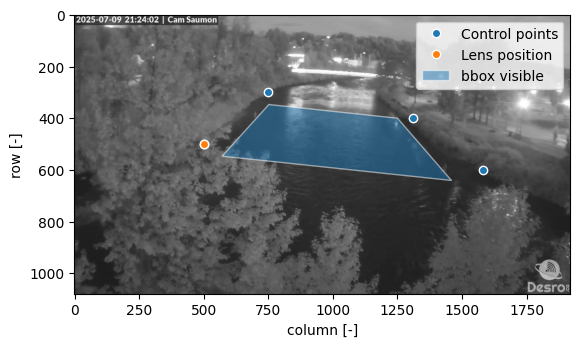

In [19]:
osm_tiler = cimgt.OSM()
tiler_crs = osm_tiler.crs

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=tiler_crs)

# Ajouter les tuiles
ax.add_image(osm_tiler, 17)  # Zoom 17 (modifie selon ton besoin)

# Ajouter ensuite des éléments de pyOpenRiverCam sur ce même ax
cam_config.plot(ax=ax, mode="geographical")

f = plt.figure()
ax2 = plt.axes()
ax2.imshow(frame)
cam_config.plot(ax=ax2, camera=True)

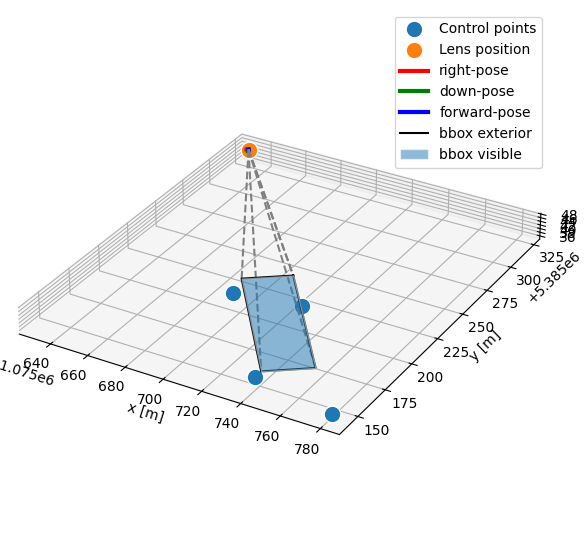

In [20]:
plt.close("all")
f = plt.figure(figsize=(12, 7))
ax = f.add_subplot(projection="3d")
cam_config.plot(mode="3d", ax=ax)
ax.set_aspect("equal")

In [21]:
cam_config.to_file("./artifact/configCam.json")